In [2588]:
import numpy as np
import matplotlib.pyplot as plt

In [2589]:
from loaders import clean_text_for_pattern_letter
from temp_text import template_str
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', '\'', '1']
print(f'{letters=}')

len(letters)=32
500
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', "'", '1']


In [2590]:
def predict_train(input_str, letters, max_index:int = 4,):
    next_index: dict[str, int] = {}
    index_by_prev: dict[str, dict] = {}

    StatsDict: dict[str, dict] = {}

    for letter in letters:
        next_index[letter] = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]
        
        inp_index = next_index[inp]

        prev_index = next_index[prev_inp]

        stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
        StatsDict.setdefault(stats_key, {})

        next_inp = input_str[inp_idx + 1]
        StatsDict[stats_key].setdefault(next_inp, 0)

        StatsDict[stats_key][next_inp] += 1

        by_prev_key = prev_inp + str(prev_index) + ':' + inp
        index_by_prev.setdefault(by_prev_key, {})
        index_by_prev[by_prev_key].setdefault(inp_index, 0)
        index_by_prev[by_prev_key][inp_index] += 1

        by_prev_key = prev_inp + str(0) + ':' + inp
        index_by_prev.setdefault(by_prev_key, {})
        index_by_prev[by_prev_key].setdefault(inp_index, 0)
        index_by_prev[by_prev_key][inp_index] += 1
        
        next_index[prev_inp] += 1
        if next_index[prev_inp] > max_index:
            next_index[prev_inp] = 1
    
    return StatsDict, index_by_prev

In [2591]:
def predict(input_str, TF:list, StatsDict:dict, index_by_prev:dict, max_index, err = 0,):
    prev_index_l = [x for x in range(1, max_index+1)]

    output = []

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]
        
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index:
                max_key_d = 1
            
            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
            # B B {'B': 1} [3] {3: 1} [3] False
            output.append(max_key)

        prev_index_l = list(index_d.keys())
        
        if max_key != next_inp:
            err += 1

        stats_arr = np.array(list(stats_d.values()))
        predictability = np.sum(np.abs(stats_arr - stats_arr[np.newaxis].T))
        tf = predictability
        TF.append(tf)
    
    output.insert(0, input_str[1])
    
    return TF, err, output

In [2592]:
# train
max_index_L1 = 4

index_by_prev_L1: dict[str, dict] = {}
StatsDict_L1: dict[str, dict] = {}

StatsDict, index_by_prev_L1 = predict_train(letters=letters, input_str=input_str, max_index=max_index_L1)

In [2593]:
for sdk, sdv in index_by_prev_L1.items():
    print(sdk, sdv)
    print('')

t1:h {1: 2}

t0:h {1: 4, 2: 2, 3: 3, 4: 2}

h1:e {1: 1, 4: 3}

h0:e {1: 1, 3: 3, 4: 5, 2: 4}

e1:  {1: 2, 4: 1}

e0:  {1: 6, 3: 4, 4: 4, 2: 3}

 1:s {1: 1}

 0:s {1: 1, 3: 2, 4: 1, 2: 2}

s1:k {1: 1}

s0:k {1: 1}

k1:y {1: 1}

k0:y {1: 1}

y1:  {2: 1}

y0:  {2: 1, 1: 2, 3: 1}

 2:a {1: 1}

 0:a {1: 3, 3: 5, 2: 2, 4: 2}

a1:b {1: 1}

a0:b {1: 1}

b1:o {1: 1}

b0:o {1: 1, 2: 2}

o1:v {1: 1}

o0:v {1: 1}

v1:e {2: 1}

v0:e {2: 1, 3: 2, 1: 1}

e2:  {3: 3, 2: 1, 1: 2}

 3:t {2: 2, 3: 1, 4: 1}

 0:t {2: 5, 4: 3, 1: 3, 3: 3}

t2:h {2: 2, 1: 2, 4: 1}

h2:e {3: 2, 2: 2}

e3:  {4: 2, 1: 1, 2: 2}

 4:p {1: 1}

 0:p {1: 2, 4: 1}

p1:o {2: 1}

p0:o {2: 1}

o2:r {1: 2}

o0:r {1: 3, 2: 2, 4: 1}

r1:t {3: 1}

r0:t {3: 1}

t3:  {1: 1}

t0:  {1: 2, 4: 1}

 1:w {1: 1}

 0:w {1: 1, 2: 2, 4: 2, 3: 2}

w1:a {2: 1}

w0:a {2: 3, 1: 2}

a2:s {2: 2, 1: 1}

a0:s {2: 2, 1: 3, 3: 3}

s2:  {2: 1, 4: 1}

s0:  {2: 2, 4: 7, 1: 2, 3: 3}

 2:t {4: 1, 2: 1, 3: 2}

t4:h {3: 2, 4: 1}

h3:e {4: 2, 2: 1}

e4:  {3: 1, 1: 1, 4

In [2594]:
for sdk, sdv in StatsDict.items():
    print(sdk, sdv)
    print('')

t1:h1 {'e': 2}

h1:e1 {' ': 1}

e1: 1 {'s': 1, 'd': 1}

 1:s1 {'k': 1}

s1:k1 {'y': 1}

k1:y1 {' ': 1}

y1: 2 {'a': 1}

 2:a1 {'b': 1}

a1:b1 {'o': 1}

b1:o1 {'v': 1}

o1:v1 {'e': 1}

v1:e2 {' ': 1}

e2: 3 {'t': 1, 's': 1, 'c': 1}

 3:t2 {'h': 2}

t2:h2 {'e': 2}

h2:e3 {' ': 2}

e3: 4 {'p': 1, 'f': 1}

 4:p1 {'o': 1}

p1:o2 {'r': 1}

o2:r1 {'t': 1, 'd': 1}

r1:t3 {' ': 1}

t3: 1 {'w': 1}

 1:w1 {'a': 1}

w1:a2 {'s': 1}

a2:s2 {' ': 1, 'e': 1}

s2: 2 {'t': 1}

 2:t4 {'h': 1}

t4:h3 {'e': 1, 'i': 1}

h3:e4 {' ': 1, 'a': 1}

e4: 3 {'c': 1}

 3:c1 {'o': 1}

c1:o3 {'l': 1}

o3:l1 {'o': 1}

l1:o4 {'r': 1}

o4:r2 {' ': 2}

r2: 4 {'o': 1}

 4:o1 {'f': 1}

o1:f1 {' ': 1}

f1: 1 {'t': 1}

 1:t1 {'e': 1}

t1:e1 {'l': 1, 's': 1}

e1:l2 {'e': 1}

l2:e2 {'v': 1}

e2:v2 {'i': 1, 'e': 1}

v2:i1 {'s': 1}

i1:s3 {'i': 1}

s3:i2 {'o': 1}

i2:o2 {'n': 1}

o2:n1 {',': 1, 'o': 1}

n1:,1 {' ': 1}

,1: 2 {'t': 1}

 2:t2 {'u': 1}

t2:u1 {'n': 1}

u1:n2 {'e': 1}

n2:e3 {'d': 1}

e3:d1 {' ': 1}

d1: 3 {'t': 1}



In [2595]:
# predict
TF = []

TF, err, out_L1 = predict(input_str=input_str, TF=TF, StatsDict=StatsDict, index_by_prev=index_by_prev_L1, max_index=max_index_L1)

print(err, err / (len(input_str) / 100) )

e e {'e': 4} [1, 2, 4, 3] {1: 4, 2: 2, 4: 2, 3: 3} [1, 2, 3, 4] False
    {' ': 4, 'a': 1, 't': 1, 'r': 1} [1, 4, 3, 2] {1: 1, 4: 5, 3: 3, 2: 4} [1, 2, 4, 3] False
s s {'s': 2, 'd': 2, 'm': 1, 'c': 1} [1, 4, 3, 2] {1: 6, 4: 4, 3: 4, 2: 3} [1, 4, 3, 2] False
p k {'k': 1, 'a': 1, 'o': 1, 'p': 2, 'h': 1} [1, 4, 3, 2] {1: 1, 4: 1, 3: 2, 2: 2} [1, 4, 3, 2] False
y y {'y': 1} [1] {1: 1} [1, 4, 3, 2] False
    {' ': 1} [1] {1: 1} [1] False
a a {'a': 1} [2] {2: 1} [1] False
b b {'b': 1} [1] {1: 1} [2] False
o o {'o': 1} [1] {1: 1} [1] False
v v {'v': 1} [1] {1: 1} [1] False
e e {'e': 1} [1] {1: 1} [1] False
    {' ': 1} [2] {2: 1} [1] False
c t {'t': 1, 's': 1, 'c': 2, 'i': 1, 'f': 1} [3, 2, 1] {3: 3, 2: 1, 1: 2} [2] False
h h {'h': 2, 'o': 1, 'e': 1} [2, 3, 4, 1] {2: 4, 3: 3, 4: 3, 1: 1} [3, 2, 1] False
e e {'e': 4, 'r': 1} [2, 1, 4, 3] {2: 2, 1: 4, 4: 2, 3: 3} [2, 3, 4, 1] False
    {' ': 4, 'r': 1, 'a': 1, 't': 1} [3, 2, 1, 4] {3: 3, 2: 4, 1: 1, 4: 5} [2, 1, 4, 3] False
s p {'p': 1, 'f': 1,

In [2596]:
# def transition_freedom(input_str: str):
#     transition_freedom: dict[str, dict] = {}

#     for inp_idx, inp in enumerate(input_str):
#         if inp_idx <= 0:
#             continue

#         prev_idx = inp_idx - 1
#         prev_inp = input_str[prev_idx]

#         transition_freedom.setdefault(prev_inp, {})
#         transition_freedom[prev_inp].setdefault(inp, 0)

#     # print(transition_freedom)

#     for tf_key, tf in transition_freedom.items():
#         transition_freedom[tf_key] = len(tf)
    
#     # print(transition_freedom)

#     return transition_freedom
        
# TF_per_symbol = transition_freedom(input_str)
# TF = []
# for inp in input_str:
#     TF.append(TF_per_symbol[inp])
# print(len(TF), TF)

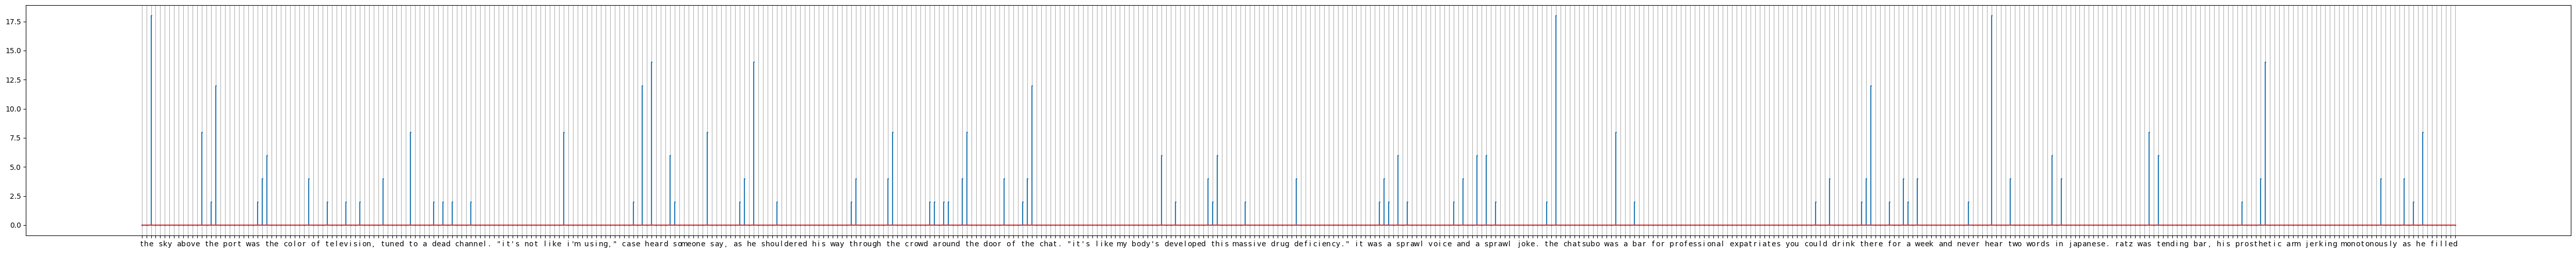

In [2597]:
TF = np.array(TF, dtype=float)
# print(TF)
TF = np.pad(TF, (1, 1), constant_values=[0,0])
# # print(TF)
# TF = np.pad(TF, (1, 0))[:-1] - TF
# TF = TF - np.pad(TF, (1, 0))[:-1] 
# # TF = np.pad(TF, (1, 0))[:-1] - TF
# # TF = TF - np.pad(TF, (0, 1))[-1:]
# # print(TF)
# TF[np.where(TF < 0)] = 0

for idx in range(1):
    TF = TF - np.pad(TF, (1, 0))[:-1]
    TF[np.where(TF < 0)] = 0
    # TF[np.where(TF <= np.mean(TF[np.where(TF > 0)]))] = 0
# # TF = np.abs(TF)
# TF[np.where(TF <= np.mean(TF[np.where(TF > 0)]))] = 0
# # TF[np.where(TF <= 0.5)] = 0
# print(TF.size, TF.max(), TF.min())
# TF[np.where(TF <= np.mean(TF))] = 0

fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
# axs.plot(np.arange(TF.size), TF)
markerline, stemline, baseline, = axs.stem(np.arange(TF.size), TF)
plt.setp(markerline, markersize = 1)
axs.xaxis.set_ticks(np.arange(len(input_str)) ,input_str)
axs.xaxis.grid(True)

plt.show()

In [2598]:
upstream_inp: dict[int, list] = {}

temp_seq = []

for inp_idx, inp in enumerate(input_str):
    tf = TF[inp_idx]
    
    if tf > 0:
        upstream_inp.setdefault(inp_idx, temp_seq.copy())
        temp_seq.clear()

    temp_seq.append(inp)

for item, val in upstream_inp.items():
    print(item, val)
    
print(len(upstream_inp))

2 ['t', 'h']
13 ['e', ' ', 's', 'k', 'y', ' ', 'a', 'b', 'o', 'v', 'e']
15 [' ', 't']
16 ['h']
25 ['e', ' ', 'p', 'o', 'r', 't', ' ', 'w', 'a']
26 ['s']
27 [' ']
36 ['t', 'h', 'e', ' ', 'c', 'o', 'l', 'o', 'r']
40 [' ', 'o', 'f', ' ']
44 ['t', 'e', 'l', 'e']
47 ['v', 'i', 's']
52 ['i', 'o', 'n', ',', ' ']
58 ['t', 'u', 'n', 'e', 'd', ' ']
63 ['t', 'o', ' ', 'a', ' ']
65 ['d', 'e']
67 ['a', 'd']
71 [' ', 'c', 'h', 'a']
91 ['n', 'n', 'e', 'l', '.', ' ', '"', 'i', 't', "'", 's', ' ', 'n', 'o', 't', ' ', 'l', 'i', 'k', 'e']
106 [' ', 'i', "'", 'm', ' ', 'u', 's', 'i', 'n', 'g', ',', '"', ' ', 'c', 'a']
108 ['s', 'e']
110 [' ', 'h']
114 ['e', 'a', 'r', 'd']
115 [' ']
122 ['s', 'o', 'm', 'e', 'o', 'n', 'e']
129 [' ', 's', 'a', 'y', ',', ' ', 'a']
130 ['s']
132 [' ', 'h']
137 ['e', ' ', 's', 'h', 'o']
153 ['u', 'l', 'd', 'e', 'r', 'e', 'd', ' ', 'h', 'i', 's', ' ', 'w', 'a', 'y', ' ']
154 ['t']
161 ['h', 'r', 'o', 'u', 'g', 'h', ' ']
162 ['t']
170 ['h', 'e', ' ', 'c', 'r', 'o', 'w', 'd']
171 

In [2599]:
letters_dict: dict[str, int] = {}
for let_idx, letter in enumerate(letters):
    letters_dict.setdefault(letter, let_idx)

upstream_patterns = []

for upstream_letters in upstream_inp.values():
    upstream_pattern = np.zeros(len(letters))

    for letter in upstream_letters:
        pattern_idx = letters_dict.get(letter, 0)

        upstream_pattern[pattern_idx] = 1
    
    upstream_patterns.append(upstream_pattern)

upstream_patterns = np.array(upstream_patterns)

for up_ptr in upstream_patterns:
    print(up_ptr.astype(int).tolist())

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [2600]:
layer_size = 32

I = np.zeros(upstream_patterns.shape[1])
O = np.zeros(layer_size)
W = np.ones((O.size, I.size))
Trace = np.zeros((O.size, I.size))
print('W', W.shape, W.max(), W.min(), np.median(W))

k = 1
push_delta = 0.4

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

eps = 0.05
rate_drop = 0.0

AVG_O = np.zeros(O.shape)
AVG_O_CNT = np.zeros(O.shape)

samples_idx = np.arange(upstream_patterns.shape[0])

for epoch_idx in range(epoch_cnt):
    np.random.shuffle(samples_idx)

    for i_idx in samples_idx:
        I = upstream_patterns[i_idx]

        # infer
        O = np.dot(W, I)

        # train
        winner_ids = np.argsort(O)[::-1][:1+k]
        winner = winner_ids[0]
        loosers = winner_ids[1:1+k]

        # update
        W[winner] = (1 - eps) * W[winner] + eps * (I - 0.5) + Trace[winner]*eps
        W[winner] = np.clip(W[winner], -1, 1)

        # W[loosers] = (1 - eps) * W[loosers] + (eps * (I - 0.5) * -push_delta) + Trace[loosers]*eps
        # W[loosers] = np.clip(W[loosers], -1, 1)

        # update Trace
        rate_Trace = np.zeros(I.shape)
        rate_Trace[(I > 0.5)] = 0.3
        rate_Trace[(I < 0.5)] = -0.001

        dTrace = np.zeros(W.shape)
        dTrace[winner] = rate_Trace
        Trace += dTrace
        Trace = np.clip(Trace, 0, 1)

        eps -= eps * rate_drop

print('W', W.shape, W.max(), W.min(), np.median(W))

W (32, 32) 1.0 1.0 1.0
W (32, 32) 1.0 -0.4999999999999995 -0.4835650448038909


In [2601]:
SL_symbols = [x.capitalize() for x in letters][:layer_size]
print(len(SL_symbols))

SLSymbolDict = {}

SL_symbols_d = {}
for idx, val in enumerate(SL_symbols):
    SL_symbols_d.setdefault(val + ':' + str(idx), 0)

upstream_inp_keys = list(upstream_inp.keys())

upstream_cluster_by_symbol: dict[str, int] = {}
for idx, val in enumerate(SL_symbols):
    upstream_cluster_by_symbol.setdefault(val, idx)

for upstr_idx, up_ptr in enumerate(upstream_patterns):
    O = np.dot(W, up_ptr)

    winner = np.argmax(O)
    symbol = SL_symbols[winner]
    print(SL_symbols[winner])

    # print(W[upstream_cluster_by_symbol[symbol]].tolist())

    sls = SL_symbols[winner]
    sls_key = upstream_inp_keys[upstr_idx]
    SLSymbolDict.setdefault(sls_key, sls)
    
    SL_symbols_d[SL_symbols[winner] + ':' + str(winner)] += 1

print(len(SL_symbols_d))
for key, val in SL_symbols_d.items():
    print(key, val)

print(SLSymbolDict)

32
'
O
K
B
K
C
A
K
D
K
Y
 
K
K
I
R
K
 
 
C
,
R
A
 
X
C
,
K
K
J
E
J
K
A
E
D
H
A
K
D
J
B
K
I
T
A
J
K
I
K
C
A
O
N
M
O
F
O
N
E
'
K
X
K
U
F
J
B
M
D
A
O
K
M
E
K
 
E
X
R
J
B
 
K
V
,
32
A:0 7
B:1 4
C:2 4
D:3 4
E:4 5
F:5 2
G:6 0
H:7 1
I:8 3
J:9 6
K:10 19
L:11 0
M:12 3
N:13 2
O:14 5
P:15 0
Q:16 0
R:17 3
S:18 0
T:19 1
U:20 1
V:21 1
W:22 0
X:23 3
Y:24 1
Z:25 0
 :26 6
.:27 0
,:28 3
":29 0
':30 2
1:31 0
{2: "'", 13: 'O', 15: 'K', 16: 'B', 25: 'K', 26: 'C', 27: 'A', 36: 'K', 40: 'D', 44: 'K', 47: 'Y', 52: ' ', 58: 'K', 63: 'K', 65: 'I', 67: 'R', 71: 'K', 91: ' ', 106: ' ', 108: 'C', 110: ',', 114: 'R', 115: 'A', 122: ' ', 129: 'X', 130: 'C', 132: ',', 137: 'K', 153: 'K', 154: 'J', 161: 'E', 162: 'J', 170: 'K', 171: 'A', 173: 'E', 174: 'D', 177: 'H', 178: 'A', 186: 'K', 190: 'D', 191: 'J', 192: 'B', 220: 'K', 223: 'I', 230: 'T', 231: 'A', 232: 'J', 238: 'K', 249: 'I', 267: 'K', 268: 'C', 269: 'A', 271: 'O', 273: 'N', 283: 'M', 285: 'O', 288: 'F', 290: 'O', 292: 'N', 303: 'E', 305: "'", 318: 'K', 322: 

In [2602]:
sl_input = list(SLSymbolDict.values())
print(sl_input)

["'", 'O', 'K', 'B', 'K', 'C', 'A', 'K', 'D', 'K', 'Y', ' ', 'K', 'K', 'I', 'R', 'K', ' ', ' ', 'C', ',', 'R', 'A', ' ', 'X', 'C', ',', 'K', 'K', 'J', 'E', 'J', 'K', 'A', 'E', 'D', 'H', 'A', 'K', 'D', 'J', 'B', 'K', 'I', 'T', 'A', 'J', 'K', 'I', 'K', 'C', 'A', 'O', 'N', 'M', 'O', 'F', 'O', 'N', 'E', "'", 'K', 'X', 'K', 'U', 'F', 'J', 'B', 'M', 'D', 'A', 'O', 'K', 'M', 'E', 'K', ' ', 'E', 'X', 'R', 'J', 'B', ' ', 'K', 'V', ',']


In [2603]:
# SL train
max_index_L2 = 8

StatsDict_L2, index_by_prev_L2 = predict_train(input_str=sl_input, letters=SL_symbols, max_index=max_index_L2)

In [2604]:
for sdk, sdv in StatsDict_L2.items():
    print(sdk, sdv)
    print('')

'1:O1 {'K': 1}

O1:K1 {'B': 1}

K1:B1 {'K': 1}

B1:K2 {'C': 1}

K2:C1 {'A': 1}

C1:A1 {'K': 1}

A1:K3 {'D': 1}

K3:D1 {'K': 1}

D1:K4 {'Y': 1}

K4:Y1 {' ': 1}

Y1: 1 {'K': 1}

 1:K5 {'K': 1}

K5:K5 {'I': 1}

K6:I1 {'R': 1}

I1:R1 {'K': 1}

R1:K7 {' ': 1}

K7: 2 {' ': 1}

 2: 2 {'C': 1}

 3:C2 {',': 1}

C2:,1 {'R': 1}

,1:R2 {'A': 1}

R2:A2 {' ': 1}

A2: 4 {'X': 1}

 4:X1 {'C': 1}

X1:C3 {',': 1}

C3:,2 {'K': 1}

,2:K8 {'K': 1}

K8:K8 {'J': 1}

K1:J1 {'E': 1}

J1:E1 {'J': 1}

E1:J2 {'K': 1}

J2:K2 {'A': 1}

K2:A3 {'E': 1}

A3:E2 {'D': 1}

E2:D2 {'H': 1}

D2:H1 {'A': 1}

H1:A4 {'K': 1}

A4:K3 {'D': 1}

K3:D3 {'J': 1}

D3:J3 {'B': 1}

J3:B2 {'K': 1}

B2:K4 {'I': 1}

K4:I2 {'T': 1}

I2:T1 {'A': 1}

T1:A5 {'J': 1}

A5:J4 {'K': 1}

J4:K5 {'I': 1}

K5:I3 {'K': 1}

I3:K6 {'C': 1}

K6:C4 {'A': 1}

C4:A6 {'O': 1}

A6:O2 {'N': 1}

O2:N1 {'M': 1}

N1:M1 {'O': 1}

M1:O3 {'F': 1}

O3:F1 {'O': 1}

F1:O4 {'N': 1}

O4:N2 {'E': 1}

N2:E3 {"'": 1}

E3:'2 {'K': 1}

'2:K7 {'X': 1}

K7:X2 {'K': 1}

X2:K8 {'

In [2605]:
for sdk, sdv in index_by_prev_L2.items():
    print(sdk, sdv)
    print('')

'1:O {1: 1}

'0:O {1: 1}

O1:K {1: 1}

O0:K {1: 2}

K1:B {1: 1}

K0:B {1: 1}

B1:K {2: 1}

B0:K {2: 1, 4: 1}

K2:C {1: 1}

K0:C {1: 1, 4: 1}

C1:A {1: 1}

C0:A {1: 1, 6: 1}

A1:K {3: 1}

A0:K {3: 2}

K3:D {1: 1, 3: 1}

K0:D {1: 1, 3: 1}

D1:K {4: 1}

D0:K {4: 1}

K4:Y {1: 1}

K0:Y {1: 1}

Y1:  {1: 1}

Y0:  {1: 1}

 1:K {5: 1}

 0:K {5: 1, 3: 1}

K5:K {5: 1}

K0:K {5: 1, 8: 1}

K6:I {1: 1}

K0:I {1: 1, 2: 1, 3: 1}

I1:R {1: 1}

I0:R {1: 1}

R1:K {7: 1}

R0:K {7: 1}

K7:  {2: 1}

K0:  {2: 1, 5: 1}

 2:  {2: 1}

 0:  {2: 1}

 3:C {2: 1}

 0:C {2: 1}

C2:, {1: 1}

C0:, {1: 1, 2: 1}

,1:R {2: 1}

,0:R {2: 1}

R2:A {2: 1}

R0:A {2: 1}

A2:  {4: 1}

A0:  {4: 1}

 4:X {1: 1}

 0:X {1: 1}

X1:C {3: 1}

X0:C {3: 1}

C3:, {2: 1}

,2:K {8: 1}

,0:K {8: 1}

K8:K {8: 1}

K1:J {1: 1}

K0:J {1: 1}

J1:E {1: 1}

J0:E {1: 1}

E1:J {2: 1}

E0:J {2: 1}

J2:K {2: 1}

J0:K {2: 1, 5: 1}

K2:A {3: 1}

K0:A {3: 1}

A3:E {2: 1}

A0:E {2: 1}

E2:D {2: 1}

E0:D {2: 1}

D2:H {1: 1}

D0:H {1: 1}

H1:A {4: 1}

H0:A 

In [2606]:
# predict
TF_L2 = []

TF_L2, err_L2, out_L2 = predict(input_str=sl_input, 
                                TF=TF_L2, 
                                StatsDict=StatsDict_L2, 
                                index_by_prev=index_by_prev_L2, 
                                max_index=max_index_L2)

for o in out_L2:
    print(o)

print(err_L2, err_L2 / (len(sl_input) / 100), len(sl_input), len(out_L2) )

K K {'K': 1} [1] {1: 1} [1, 2, 3, 4, 5, 6, 7, 8] False
B B {'B': 1} [1] {1: 1} [1] False
K K {'K': 1} [1] {1: 1} [1] False
C C {'C': 1} [2] {2: 1} [1] False
A A {'A': 1} [1] {1: 1} [2] False
K K {'K': 1} [1] {1: 1} [1] False
D D {'D': 1} [3] {3: 1} [1] False
K K {'K': 1, 'J': 1} [1, 3] {1: 1, 3: 1} [3] False
Y Y {'Y': 1} [4] {4: 1} [1, 3] False
    {' ': 1} [1] {1: 1} [4] False
K K {'K': 1} [1] {1: 1} [1] False
K K {'K': 1} [5] {5: 1} [1] False
I I {'I': 1} [5] {6: 1} [5] True
R R {'R': 1} [1] {1: 1} [6] False
K K {'K': 1} [1] {1: 1} [1] False
    {' ': 1} [7] {7: 1} [1] False
    {' ': 1} [2] {2: 1} [7] False
C C {'C': 1} [2] {3: 1} [2] True
, , {',': 1} [2] {2: 1} [3] False
R R {'R': 1} [1] {1: 1} [2] False
A A {'A': 1} [2] {2: 1} [1] False
    {' ': 1} [2] {2: 1} [2] False
X X {'X': 1} [4] {4: 1} [2] False
C C {'C': 1} [1] {1: 1} [4] False
, , {',': 1} [3] {3: 1} [1] False
K K {'K': 1} [2] {2: 1} [3] False
K K {'K': 1} [8] {8: 1} [2] False
J J {'J': 1} [8] {1: 1} [8] True
E E {'E': 

In [2607]:
def ds_predict_train_without_index(input_str: str | list,
                                   #    sl_input: list,
                                   SLSymbolDict: dict,
                                   #    StatsDict_L1: dict,
                                   #    index_by_prev_L1: dict,
                                   #    max_index_L1: int,
                                   ):
    ds_symbol = '0'
    DsSymbolsStats = {}
    DsSymbolsStatsProb = {}

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        peak_symbol = SLSymbolDict.get(inp_idx, 0)  # inp_idx - 1
        if peak_symbol != 0:
            ds_symbol = peak_symbol

        DsSymbolsStats.setdefault(ds_symbol, {})
        DsSymbolsStats[ds_symbol].setdefault(inp, 0)

        DsSymbolsStats[ds_symbol][inp] += 1

    for ds_inp, inps in DsSymbolsStats.items():
        norm = sum(inps.values())

        for symbol, symbol_stats in inps.items():
            DsSymbolsStatsProb[ds_inp + ':' + symbol] = symbol_stats / norm

    return DsSymbolsStats, DsSymbolsStatsProb

In [2608]:
DsSymbolsStats, DsSymbolsStatsProb = ds_predict_train_without_index(input_str, SLSymbolDict)
print(DsSymbolsStatsProb)

{'0:h': 1.0, "':e": 0.125, "': ": 0.16666666666666666, "':s": 0.08333333333333333, "':k": 0.041666666666666664, "':y": 0.041666666666666664, "':a": 0.125, "':b": 0.08333333333333333, "':o": 0.08333333333333333, "':v": 0.041666666666666664, "':c": 0.041666666666666664, "':h": 0.041666666666666664, "':t": 0.041666666666666664, "':u": 0.041666666666666664, "':w": 0.041666666666666664, 'O: ': 0.2, 'O:t': 0.05, 'O:s': 0.1, 'O:p': 0.1, 'O:n': 0.15, 'O:d': 0.1, 'O:w': 0.05, 'O:e': 0.15, 'O:k': 0.05, 'O:a': 0.05, 'K:h': 0.033707865168539325, 'K:s': 0.10112359550561797, 'K: ': 0.2247191011235955, 'K:o': 0.0449438202247191, 'K:f': 0.02247191011235955, 'K:v': 0.033707865168539325, 'K:i': 0.06741573033707865, 'K:t': 0.0449438202247191, 'K:a': 0.0449438202247191, 'K:d': 0.06741573033707865, 'K:e': 0.0898876404494382, 'K:n': 0.033707865168539325, 'K:l': 0.0449438202247191, 'K:.': 0.011235955056179775, 'K:"': 0.011235955056179775, "K:'": 0.011235955056179775, 'K:k': 0.011235955056179775, 'K:u': 0.033

In [2609]:
# from itertools import cycle

def ds_predict(input_str, 
               StatsDict: dict, 
               index_by_prev: dict,
               upstream_cluster_by_symbol: dict,
               letters_dict: dict,
               out_L2: list,
               SLSymbolDict: dict,
               W,
               DsSymbolsStats: dict,
               max_index):
    prev_index_l = [x for x in range(1, max_index+1)]

    err = 0
    TF = []
    output = []

    ds_out_idx = 0
    ds_inp = '0'
    # ds_pattern = np.ones(W.shape[1])

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]
        
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        # downstream
        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if ds_out_idx == len(out_L2):
                ds_inp = '0'
                # ds_pattern = np.ones(W.shape[1])
            else:
                ds_inp = out_L2[ds_out_idx]
                # ds_pattern = W[upstream_cluster_by_symbol.get(ds_inp)]
                # ds_pattern = np.copy(W[upstream_cluster_by_symbol.get(ds_inp)])
                # ds_pattern[np.where(ds_pattern < 0)] = 0

                ds_out_idx += 1
        print(stats_d)

        # prob stats
        # norm = sum(stats_d.values())
        # for st_key, st in stats_d.items():
        #     stats_d[st_key] = st / norm

        for st_key, st in stats_d.items():
            # letter_idx = letters_dict.get(st_key)
            
            # ds_stats = ds_pattern[letter_idx]
            ds_key = ds_inp + ':' + st_key
            ds_stats = DsSymbolsStats.get(ds_key, 0)
            print('st_ds:', st_key, st, ds_key, ds_stats)
            if ds_stats <= 0:
                stats_d[st_key] = 0

                continue
            
            stats_d[st_key] *= ds_stats
            print('upd:', ds_stats)
        
        print(stats_d)
        print(input_str[inp_idx + 1], max(stats_d, key=stats_d.get))
        print()

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index:
                max_key_d = 1
            
            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            # print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
            output.append(max_key)

        prev_index_l = list(index_d.keys())
        
        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)
    
    output.insert(0, input_str[1])
    
    return TF, err, output

In [2610]:
DsSymbolsStats, DsSymbolsStatsProb = ds_predict_train_without_index(input_str, SLSymbolDict)

dsp_TF, dsp_err, dsp_output = ds_predict(input_str=input_str,
                                         StatsDict=StatsDict,
                                         index_by_prev=index_by_prev_L1,
                                         upstream_cluster_by_symbol=upstream_cluster_by_symbol,
                                         letters_dict=letters_dict,
                                         out_L2=out_L2,
                                         SLSymbolDict=SLSymbolDict,
                                         W=W,
                                         DsSymbolsStats=DsSymbolsStatsProb,
                                         max_index=max_index_L1)

print(dsp_err, dsp_err / (len(input_str) / 100))


{'e': 4}
st_ds: e 4 0:e 0
{'e': 0}
e e

{' ': 4, 'a': 1, 't': 1, 'r': 1}
st_ds:   4 O:  0.2
upd: 0.2
st_ds: a 1 O:a 0.05
upd: 0.05
st_ds: t 1 O:t 0.05
upd: 0.05
st_ds: r 1 O:r 0
{' ': 0.8, 'a': 0.05, 't': 0.05, 'r': 0}
   

{'s': 2, 'd': 2, 'm': 1, 'c': 1}
st_ds: s 2 O:s 0.1
upd: 0.1
st_ds: d 2 O:d 0.1
upd: 0.1
st_ds: m 1 O:m 0
st_ds: c 1 O:c 0
{'s': 0.2, 'd': 0.2, 'm': 0, 'c': 0}
s s

{'k': 1, 'a': 1, 'o': 1, 'p': 2, 'h': 1}
st_ds: k 1 O:k 0.05
upd: 0.05
st_ds: a 1 O:a 0.05
upd: 0.05
st_ds: o 1 O:o 0
st_ds: p 2 O:p 0.1
upd: 0.1
st_ds: h 1 O:h 0
{'k': 0.05, 'a': 0.05, 'o': 0, 'p': 0.2, 'h': 0}
k p

{'y': 1}
st_ds: y 1 O:y 0
{'y': 0}
y y

{' ': 1}
st_ds:   1 O:  0.2
upd: 0.2
{' ': 0.2}
   

{'a': 1}
st_ds: a 1 O:a 0.05
upd: 0.05
{'a': 0.05}
a a

{'b': 1}
st_ds: b 1 O:b 0
{'b': 0}
b b

{'o': 1}
st_ds: o 1 O:o 0
{'o': 0}
o o

{'v': 1}
st_ds: v 1 O:v 0
{'v': 0}
v v

{'e': 1}
st_ds: e 1 O:e 0.15
upd: 0.15
{'e': 0.15}
e e

{' ': 1}
st_ds:   1 O:  0.2
upd: 0.2
{' ': 0.2}
   

{'t': 1, 's': 1,

In [2611]:
ds_predict_train_without_index(input_str, SLSymbolDict)

({'0': {'h': 1},
  "'": {'e': 3,
   ' ': 4,
   's': 2,
   'k': 1,
   'y': 1,
   'a': 3,
   'b': 2,
   'o': 2,
   'v': 1,
   'c': 1,
   'h': 1,
   't': 1,
   'u': 1,
   'w': 1},
  'O': {' ': 4,
   't': 1,
   's': 2,
   'p': 2,
   'n': 3,
   'd': 2,
   'w': 1,
   'e': 3,
   'k': 1,
   'a': 1},
  'K': {'h': 3,
   's': 9,
   ' ': 20,
   'o': 4,
   'f': 2,
   'v': 3,
   'i': 6,
   't': 4,
   'a': 4,
   'd': 6,
   'e': 8,
   'n': 3,
   'l': 4,
   '.': 1,
   '"': 1,
   "'": 1,
   'k': 1,
   'u': 3,
   'r': 3,
   'w': 1,
   'y': 1,
   'g': 1},
  'B': {'e': 7,
   ' ': 11,
   'p': 1,
   'o': 6,
   'r': 4,
   't': 5,
   'w': 1,
   'a': 3,
   'c': 2,
   'h': 1,
   '.': 1,
   '"': 1,
   'i': 4,
   "'": 2,
   's': 2,
   'l': 1,
   'k': 2,
   'm': 3,
   'y': 2,
   'b': 1,
   'd': 1,
   'j': 1,
   'n': 3,
   'g': 1},
  'C': {' ': 4, 'h': 2},
  'A': {'t': 3,
   'h': 2,
   'e': 4,
   ' ': 4,
   'c': 1,
   'o': 6,
   'l': 1,
   'r': 3,
   's': 1,
   'm': 1,
   'n': 1,
   'a': 3,
   'd': 1},
  'D': {'t': 

In [2612]:
def downstream_predict_train(input_str: str | list,
                             sl_input: list,
                             SLSymbolDict: dict,
                            #  ds_out: list,
                             StatsDict_L1: dict,
                            #  StatsDict_L2,
                            #  TF_L1,
                             index_by_prev_L1: dict,
                            #  index_by_prev_L2,
                             max_index_L1: int,
                            #  max_index_L2,
                             ):
    next_index: dict[str, int] = {}

    for letter in letters:
        next_index[letter] = 1

    ds_inp = '0'
    sl_inp_idx = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]

        inp_index = next_index[inp]

        prev_index = next_index[prev_inp]

        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if sl_inp_idx == len(sl_input):
                ds_inp = '0'
            else:
                ds_inp = sl_input[sl_inp_idx]
                sl_inp_idx += 1
        # print(f'{ds_inp=}')
        stats_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp + str(inp_index)
        StatsDict_L1.setdefault(stats_key, {})

        next_inp = input_str[inp_idx + 1]
        StatsDict_L1[stats_key].setdefault(next_inp, 0)

        StatsDict_L1[stats_key][next_inp] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(0) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        next_index[prev_inp] += 1
        if next_index[prev_inp] > max_index_L1:
            next_index[prev_inp] = 1
        
    return StatsDict_L1, index_by_prev_L1


In [2613]:
StatsDict_L1_ds = {}
index_by_prev_L1_ds = {}

StatsDict_L1_ds, index_by_prev_L1_ds = downstream_predict_train(input_str=input_str,
                                                                sl_input=sl_input,
                                                                SLSymbolDict=SLSymbolDict,
                                                                StatsDict_L1=StatsDict_L1_ds,
                                                                index_by_prev_L1=index_by_prev_L1_ds,
                                                                max_index_L1=max_index_L1, )

for key, val in StatsDict_L1_ds.items():
    print(key, val)

0:t1:h1 {'e': 1}
O:h1:e1 {' ': 1}
O:e1: 1 {'s': 1}
O: 1:s1 {'k': 1}
O:s1:k1 {'y': 1}
O:k1:y1 {' ': 1}
O:y1: 2 {'a': 1}
O: 2:a1 {'b': 1}
O:a1:b1 {'o': 1}
O:b1:o1 {'v': 1}
O:o1:v1 {'e': 1}
O:v1:e2 {' ': 1}
K:e2: 3 {'t': 1, 'c': 1}
K: 3:t2 {'h': 1}
B:t2:h2 {'e': 2}
K:h2:e3 {' ': 2}
K:e3: 4 {'p': 1}
K: 4:p1 {'o': 1}
K:p1:o2 {'r': 1}
K:o2:r1 {'t': 1, 'd': 1}
K:r1:t3 {' ': 1}
K:t3: 1 {'w': 1}
K: 1:w1 {'a': 1}
K:w1:a2 {'s': 1}
C:a2:s2 {' ': 1, 'e': 1}
A:s2: 2 {'t': 1}
K: 2:t4 {'h': 1}
K:t4:h3 {'e': 1, 'i': 1}
K:h3:e4 {' ': 1}
K:e4: 3 {'c': 1}
K: 3:c1 {'o': 1}
K:c1:o3 {'l': 1}
K:o3:l1 {'o': 1}
K:l1:o4 {'r': 1}
K:o4:r2 {' ': 1}
D:r2: 4 {'o': 1}
D: 4:o1 {'f': 1}
D:o1:f1 {' ': 1}
D:f1: 1 {'t': 1}
K: 1:t1 {'e': 1}
K:t1:e1 {'l': 1, 's': 1}
K:e1:l2 {'e': 1}
K:l2:e2 {'v': 1}
Y:e2:v2 {'i': 1}
Y:v2:i1 {'s': 1}
Y:i1:s3 {'i': 1}
 :s3:i2 {'o': 1}
 :i2:o2 {'n': 1}
 :o2:n1 {',': 1, 'o': 1}
 :n1:,1 {' ': 1}
 :,1: 2 {'t': 1}
K: 2:t2 {'u': 1}
K:t2:u1 {'n': 1}
K:u1:n2 {'e': 1}
K:n2:e3 {'d': 1}
K:e3:d1 {' ': 1}


In [2614]:
from itertools import cycle

print(out_L2)
def downstream_predict(input_str: str | list,
                       SLSymbolDict: dict,
                       StatsDict_L1_ds: dict,
                       index_by_prev_L1_ds: dict,
                       out_L2: list,
                       max_index_L1: int,
                       TF: list,
                       err=0,):
    prev_index_l = [x for x in range(1, max_index_L1+1)]

    ds_inp = '0'
    ds_out_idx = 0
    ds_predict_out = cycle(out_L2)

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]

        # print(inp, SLSymbolDict.get(inp_idx, 0))
        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if ds_out_idx == len(out_L2):
                ds_inp = '0'
            else:
                ds_inp = out_L2[ds_out_idx]
                ds_out_idx += 1
        print(ds_inp, is_peak)
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev_L1_ds.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = ds_inp + ':' + prev_inp + \
                        str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict_L1_ds.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index_L1:
                max_key_d = 1

            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            # print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)

        prev_index_l = list(index_d.keys())

        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)

    return TF, err


['O', 'K', 'B', 'K', 'C', 'A', 'K', 'D', 'K', 'Y', ' ', 'K', 'K', 'I', 'R', 'K', ' ', ' ', 'C', ',', 'R', 'A', ' ', 'X', 'C', ',', 'K', 'K', 'J', 'E', 'J', 'K', 'A', 'E', 'D', 'H', 'A', 'K', 'D', 'K', 'B', 'K', 'I', 'T', 'A', 'J', 'K', 'I', 'K', 'C', 'A', 'O', 'N', 'M', 'O', 'F', 'O', 'N', 'E', "'", 'K', 'X', 'K', 'U', 'F', 'J', 'B', 'M', 'D', 'A', 'O', 'K', 'M', 'E', 'K', ' ', 'E', 'X', 'R', 'J', 'B', ' ', 'K', 'V', ',']


In [2615]:
TF_L1_ds = []

TF_L1_ds, err_L1_ds = downstream_predict(input_str=input_str,
                                         SLSymbolDict=SLSymbolDict,
                                         StatsDict_L1_ds=StatsDict_L1_ds,
                                         index_by_prev_L1_ds=index_by_prev_L1_ds,
                                         out_L2=out_L2,
                                         max_index_L1=max_index_L1,
                                         TF=TF_L1_ds, )

print(err_L1_ds, err_L1_ds / (len(input_str) / 100))

0 0
O '
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
K O
K 0
B K
K B
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
C K
A C
K A
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
D K
D 0
D 0
D 0
K D
K 0
K 0
K 0
Y K
Y 0
Y 0
  Y
  0
  0
  0
  0
K  
K 0
K 0
K 0
K 0
K 0
K K
K 0
K 0
K 0
K 0
I K
I 0
R I
R 0
K R
K 0
K 0
K 0
  K
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
   
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
C  
C 0
, C
, 0
R ,
R 0
R 0
R 0
A R
  A
  0
  0
  0
  0
  0
  0
X  
X 0
X 0
X 0
X 0
X 0
X 0
C X
, C
, 0
K ,
K 0
K 0
K 0
K 0
K K
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
J K
E J
E 0
E 0
E 0
E 0
E 0
E 0
J E
K J
K 0
K 0
K 0
K 0
K 0
K 0
K 0
A K
E A
E 0
D E
H D
H 0
H 0
A H
K A
K 0
K 0
K 0
K 0
K 0
K 0
K 0
D K
D 0
D 0
D 0
K D
B J
K B
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
I K
I 0
I 0
T I
T 0
T 0
T 0
T 0
T 0
T 0
A T
J A
K J
K 0
K 0
K 0
K 0
K 0
I K
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
K I
K 0
